# Multivariate Forecasting of Solar Power Production

In this notebook, we employ a multivariate forecasting method to predict power production. To enhance the accuracy of our predictions, we have integrated historical data for temperature (°C) and wind speed (km/h) into the original dataset. These additional features capture critical environmental factors that influence power production, especially in renewable energy applications. 

Our approach involves a comprehensive data preprocessing pipeline, followed by training an advanced encoder-decoder model that utilizes Conv1D and LSTM layers. This architecture effectively captures both local temporal patterns and long-term dependencies in the data, thereby improving the overall forecasting performance.


## 1.&nbsp; Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import datetime
from sklearn.metrics import mean_absolute_error

## 2.&nbsp; Parsing the raw data

We want to add more features to the dataset for multivariate time series analysis.

In [ ]:
Solar_PATH = './data/solar_renewables_production_cl.csv'
Solar_PATH_multivariate = './data/temp_wind_speed_info_cl.csv'

In [3]:
Solar_cl = pd.read_csv(Solar_PATH, parse_dates=["Date and Hour"])
Solar_multivariate = pd.read_csv(Solar_PATH_multivariate, parse_dates=["time"])

In [4]:
Solar_multivariate.head(2)

,time,temperature_2m (°C),wind_speed_10m (km/h)
0,2020-04-01 00:00:00+00:00,2.4,12.6
1,2020-04-01 01:00:00+00:00,2.9,11.3


In [6]:
# Drop the last 2 rows using slicing
Solar_cl = Solar_cl.iloc[2:]

In [7]:
Solar_cl.head(2)

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
2,2020-04-01 00:00:00+00:00,2020-04-01,1900-01-01 02:00:00,1900-01-01 03:00:00,Solar,0.0,92,Wednesday,April
3,2020-04-01 01:00:00+00:00,2020-04-01,1900-01-01 03:00:00,1900-01-01 04:00:00,Solar,0.0,92,Wednesday,April


In [8]:
Solar_multivariate.tail(2)

,time,temperature_2m (°C),wind_speed_10m (km/h)
28460,2023-06-30 20:00:00+00:00,15.9,15.8
28461,2023-06-30 21:00:00+00:00,14.2,14.1


In [9]:
Solar_cl.tail(2)

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
28460,2023-06-30 20:00:00+00:00,2023-06-30,1900-01-01 22:00:00,1900-01-01 23:00:00,Solar,1.0,181,Friday,June
28461,2023-06-30 21:00:00+00:00,2023-06-30,1900-01-01 23:00:00,1900-01-01 00:00:00,Solar,1.0,181,Friday,June


In [10]:
Solar_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28460 entries, 2 to 28461
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Date and Hour  28460 non-null  datetime64[ns, UTC]
 1   Date           28460 non-null  object             
 2   StartHour      28460 non-null  object             
 3   EndHour        28460 non-null  object             
 4   Source         28460 non-null  object             
 5   Production     28460 non-null  float64            
 6   dayOfYear      28460 non-null  int64              
 7   dayName        28460 non-null  object             
 8   monthName      28460 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [11]:
Solar_multivariate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28462 entries, 0 to 28461
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   time                   28462 non-null  datetime64[ns, UTC]
 1   temperature_2m (°C)    28462 non-null  float64            
 2   wind_speed_10m (km/h)  28462 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 667.2 KB


In [12]:
# Merge the DataFrames on the time columns
Solar_merged_df = pd.merge(Solar_cl, Solar_multivariate, left_on='Date and Hour', right_on='time', how='inner')

# If you don't need both time columns, you can drop one
Solar_merged_df.drop('time', axis=1, inplace=True)

In [13]:
Solar_merged_df.head(2)

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName,temperature_2m (°C),wind_speed_10m (km/h)
0,2020-04-01 00:00:00+00:00,2020-04-01,1900-01-01 02:00:00,1900-01-01 03:00:00,Solar,0.0,92,Wednesday,April,2.4,12.6
1,2020-04-01 01:00:00+00:00,2020-04-01,1900-01-01 03:00:00,1900-01-01 04:00:00,Solar,0.0,92,Wednesday,April,2.9,11.3


In [14]:
Solar_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28460 entries, 0 to 28459
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   Date and Hour          28460 non-null  datetime64[ns, UTC]
 1   Date                   28460 non-null  object             
 2   StartHour              28460 non-null  object             
 3   EndHour                28460 non-null  object             
 4   Source                 28460 non-null  object             
 5   Production             28460 non-null  float64            
 6   dayOfYear              28460 non-null  int64              
 7   dayName                28460 non-null  object             
 8   monthName              28460 non-null  object             
 9   temperature_2m (°C)    28460 non-null  float64            
 10  wind_speed_10m (km/h)  28460 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), objec

In [15]:
Solar_merged_df = Solar_merged_df.drop(columns=["Date", "StartHour", "EndHour", "Source", "dayOfYear", "dayName", "monthName"])

In [16]:
Solar_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28460 entries, 0 to 28459
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   Date and Hour          28460 non-null  datetime64[ns, UTC]
 1   Production             28460 non-null  float64            
 2   temperature_2m (°C)    28460 non-null  float64            
 3   wind_speed_10m (km/h)  28460 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(3)
memory usage: 889.5 KB


In [17]:
Solar_merged_df.to_csv("./data/Solar_multivariate_cl.csv", index=False)

In [18]:
df = Solar_merged_df.set_index('Date and Hour')

In [19]:
df.head(2)

,Production,temperature_2m (°C),wind_speed_10m (km/h)
Date and Hour,,,
2020-04-01 00:00:00+00:00,0.0,2.4,12.6
2020-04-01 01:00:00+00:00,0.0,2.9,11.3


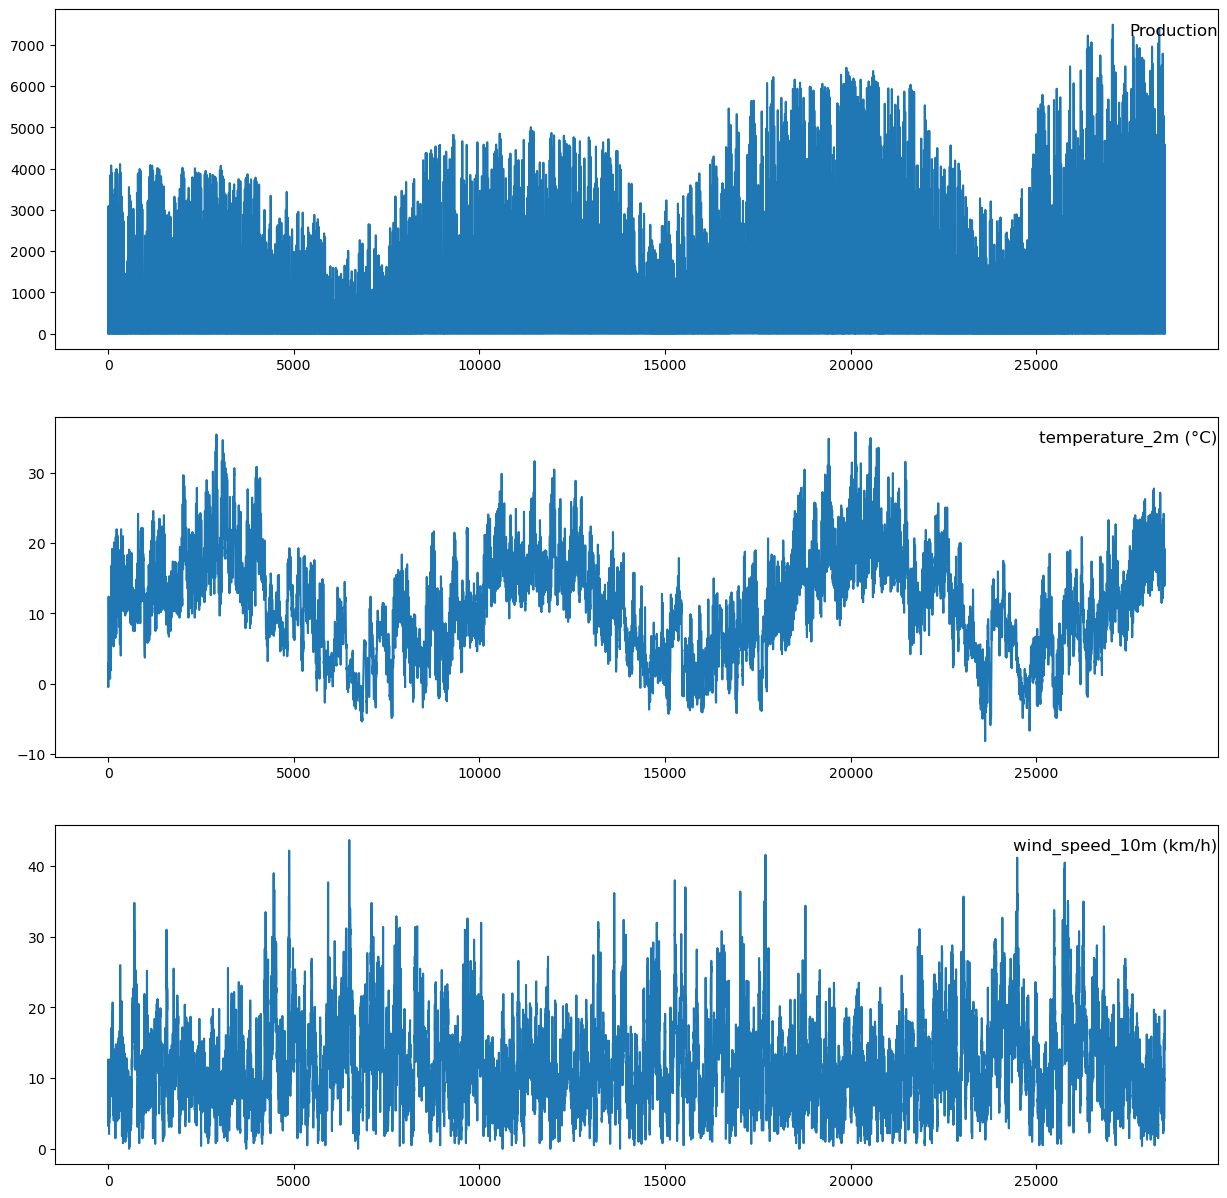

In [20]:
from matplotlib import pyplot
# load dataset
values = df.values
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.9, loc='right')
    i += 1
pyplot.show()

## 3.&nbsp; Data Preprocessing

The dataset is split into a training set (first 18,975 rows of 2 years data) and a test set (remaining rows of more than 1 year data). 

### 3.1.&nbsp; First steps:
1. Split the dataset into training and testing sets.
2. Apply `MinMaxScaler` to normalize each feature in the training data.
3. Store the scalers for future transformations.
4. Use the stored scalers to transform the test set.

In [21]:
# Splitting dataset into training and test sets
train_df,test_df = df[1:18976], df[18976:] 

In [22]:
# Copy training set
train = train_df.copy()
scalers = {}  # Dictionary to store scalers for each feature

# Apply MinMax scaling to each column in the training set
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1, 1))  # Scaling range between -1 and 1
    s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))  # Reshape for transformation
    s_s = np.reshape(s_s, len(s_s))  # Flatten the array
    scalers['scaler_' + i] = scaler  # Store scaler for later use
    train[i] = s_s  # Replace column with scaled values

# Copy test set
test = test_df.copy()

# Apply the stored scalers to the test set
for i in train_df.columns:
    scaler = scalers['scaler_' + i]  # Retrieve the corresponding scaler
    s_s = scaler.transform(test[i].values.reshape(-1, 1))  # Transform test data
    s_s = np.reshape(s_s, len(s_s))  # Flatten the array
    test[i] = s_s  # Replace column with scaled values


### 3.2.&nbsp; Function: `split_series`

This function prepares the dataset for multivariate time series forecasting by creating sequences of past observations (`X`) and future target values (`y`).

#### **Parameters:**
- `series` *(numpy array)*: The time series dataset with multiple features.
- `n_past` *(int)*: Number of past time steps to include as input features.
- `n_future` *(int)*: Number of future time steps to predict.

#### **Returns:**
- `X` *(numpy array)*: The past observations used as input features.
- `y` *(numpy array)*: The corresponding future values as target output.

#### **Process:**
1. Iterates through the dataset to extract overlapping windows of past and future data.
2. Stops when the future window exceeds the dataset length.
3. Returns `X` and `y` as numpy arrays for model training.


In [23]:
def split_series(series, n_past, n_future):
    """
    Splits a multivariate time series into overlapping sequences of past and future values.

    Parameters:
    series (numpy array): The dataset containing time series data with multiple features.
    n_past (int): Number of past time steps to use as input features.
    n_future (int): Number of future time steps to predict.

    Returns:
    tuple: (X, y) where:
        - X is a numpy array of shape (samples, n_past, features) containing past observations.
        - y is a numpy array of shape (samples, n_future, features) containing future values.
    """

    X, y = list(), list()  # Initialize empty lists for input (X) and target (y)

    # Iterate through the time series data to extract sequences
    for window_start in range(len(series)):
        past_end = window_start + n_past  # Define the end of the past time window
        future_end = past_end + n_future  # Define the end of the future time window

        # Stop if future_end exceeds dataset length
        if future_end > len(series):
            break

        # Extract past and future sequences
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)

    # Convert lists to numpy arrays for efficient computation
    return np.array(X), np.array(y)


### 3.3.&nbsp; Preparing Training and Testing Data for Multivariate Forecasting

Here, we reshape the time series dataset into a supervised learning format, where each sample consists of `n_past` time steps as input and `n_future` time steps as output.

1. Use `split_series()` to create input (`X`) and target (`y`) datasets.
2. Reshape the data to match the expected format for deep learning models like LSTMs:
   - `X_train` → `(samples, n_past, n_features)`
   - `y_train` → `(samples, n_future, n_features)`
3. Print the shapes of the resulting arrays to verify correctness.

In [24]:
# Define the sequence lengths and number of features
n_past = 60      # Number of past time steps to consider
n_future = 24    # Number of future time steps to predict
n_features = 3   # Number of features in the dataset

In [25]:
# Prepare the training dataset
X_train, y_train = split_series(train.values, n_past, n_future)

# Reshape to match deep learning model input format
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

# Prepare the test dataset
X_test, y_test = split_series(test.values, n_past, n_future)

# Reshape test data as well
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [44]:
# Print the final shapes of the datasets
print(X_train.shape)  # Expected: (num_samples, n_past, n_features)
print(y_train.shape)  # Expected: (num_samples, n_future, n_features)

(18892, 60, 3)
(18892, 24, 3)


## 4.&nbsp; Encoder-Decoder Model 

#### This model is an Encoder-Decoder (E2D2) architecture designed for multivariate time series forecasting. It consists of:
1. **Encoder**:
   - A **Conv1D** layer for capturing local temporal patterns.
   - Two stacked **LSTM** layers to extract long-term dependencies.
   - Dropout layers to prevent overfitting.
2. **Decoder**:
   - A **RepeatVector** to initialize the decoder with the last encoder state.
   - Two stacked **LSTM** layers to generate future time steps.
   - **TimeDistributed Dense** layers to produce the final output.

#### **Model Architecture**
- **Input Shape**: `(n_past, n_features)`
- **Output Shape**: `(n_future, n_features)`

#### **Key Features**
- Uses **Conv1D** to extract short-term trends in the input sequence.
- **Dropout layers** for regularization.
- **Stacked LSTMs** in both encoder and decoder.
- **TimeDistributed Dense layers** for final output generation.

In [26]:
import tensorflow as tf

# Define an Encoder-Decoder model (E2D2) with Conv1D, Dropout, and Dense layers

# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))

# Add a Conv1D layer to capture short-term temporal patterns
conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(encoder_inputs)

# Apply Dropout to reduce overfitting
drop1 = tf.keras.layers.Dropout(0.2)(conv1)

# First LSTM layer in the encoder
encoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)
encoder_outputs1 = encoder_l1(drop1)
encoder_states1 = encoder_outputs1[1:]  # Extract hidden and cell states (state_h, state_c)

# Second LSTM layer in the encoder (stacked)
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]  # Extract hidden and cell states from the second LSTM

# Decoder
# Use RepeatVector to align the decoder input shape with the future time steps
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

# First LSTM layer in the decoder, initialized with encoder_states1
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)

# Apply Dropout after the first decoder LSTM layer
drop2 = tf.keras.layers.Dropout(0.2)(decoder_l1)

# Second LSTM layer in the decoder, initialized with encoder_states2
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(drop2, initial_state=encoder_states2)

# Apply TimeDistributed Dense layers to generate output predictions
dense_decoder = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation='relu'))(decoder_l2)

# Final TimeDistributed Dense layer to match the number of features in the output
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(dense_decoder)

# Build the model
model_e2d2 = tf.keras.models.Model(encoder_inputs, decoder_outputs2)

# Print the model summary to verify the architecture
model_e2d2.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 64)    │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60, 64)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 60, 100), │     66,000 │ dropout[0][0]     │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 100),     │     80,400 │ lstm[0][0]        │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 24, 100)   │          0 │ lstm_1[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 24, 100)   │     80,400 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 100)   │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 24, 100)   │     80,400 │ dropout_1[0][0],  │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 24, 50)    │      5,050 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 24, 3)     │        153 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 313,043 (1.19 MB)

 Trainable params: 313,043 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

## 5.&nbsp; Training the E2D2 Model for Multivariate Time Series Forecasting

This section trains the **E2D2 model** using:
- **Huber Loss**: A robust loss function that handles outliers better than MSE.
- **Adam Optimizer**: Adaptive optimization for efficient learning.
- **Learning Rate Scheduler**: Gradually reduces learning rate to stabilize training.

#### **Training Parameters**
- **Epochs**: 25
- **Batch Size**: 32
- **Validation Data**: `X_test, y_test`
- **Callback**: `LearningRateScheduler` to dynamically adjust learning rate.

#### **Prediction and Visualization**
- The model's predictions are plotted against actual values.
- Assumes `y_test` and `pred_e2d2` have compatible shapes.


In [27]:
# Learning rate scheduler: reduces LR by 10% per epoch
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

# Compile the model using Adam optimizer and Huber loss for robustness
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())

# Train the model with training data and validation set
history_e2d2 = model_e2d2.fit(
    X_train, y_train, 
    epochs=25, 
    validation_data=(X_test, y_test), 
    batch_size=32, 
    verbose=0,  # Set to 1 if you want to see training progress
    callbacks=[reduce_lr]
)

In [28]:
# Make predictions on the test set
pred_e2d2 = model_e2d2.predict(X_test)

294/294 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


In [29]:
feature_names = train.columns  # Assuming train has the same structure as test
print(feature_names)

Index(['Production', 'temperature_2m (°C)', 'wind_speed_10m (km/h)'], dtype='object')


In [30]:
print("Feature Names in Data:", feature_names.tolist())
print("Feature Shape in y_test:", y_test.shape)  # (num_samples, num_future_steps, num_features)

Feature Names in Data: ['Production', 'temperature_2m (°C)', 'wind_speed_10m (km/h)']
Feature Shape in y_test: (9401, 24, 3)


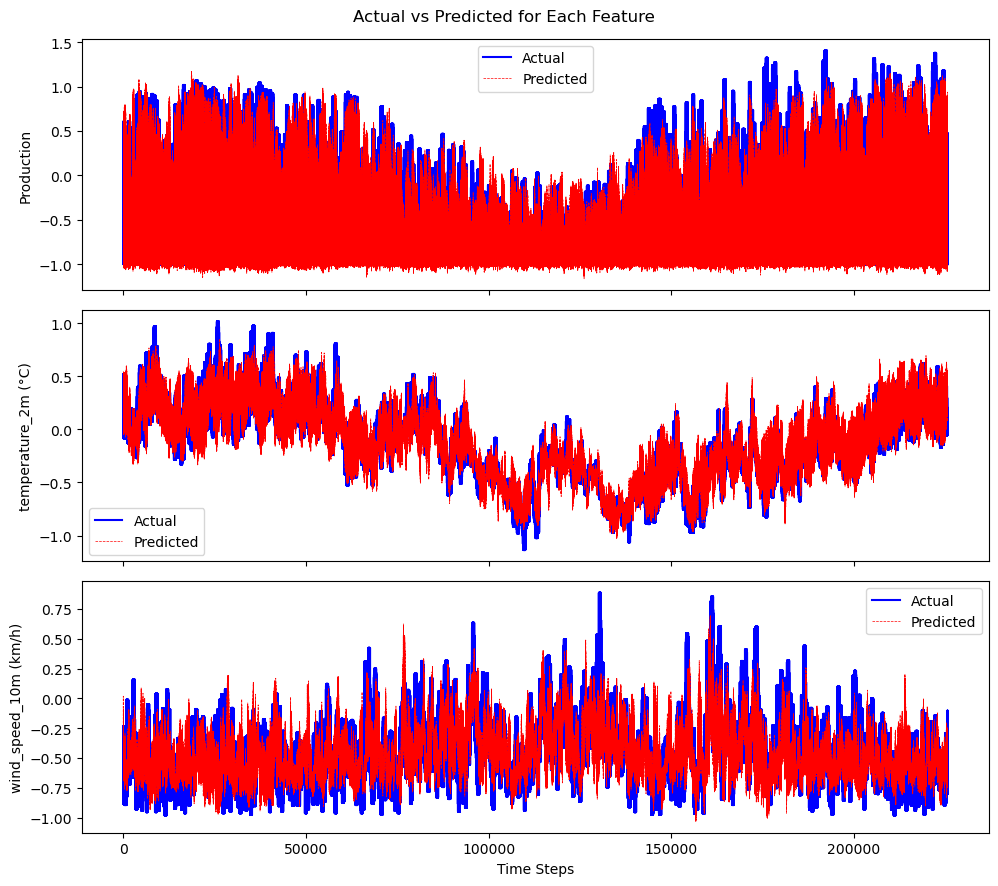

In [31]:
import matplotlib.pyplot as plt

n_features = y_test.shape[2]  # Get number of features

fig, axes = plt.subplots(n_features, 1, figsize=(10, 3 * n_features), sharex=True)

for i in range(n_features):
    axes[i].plot(y_test[:, :, i].flatten(), label="Actual", color='blue', linewidth=1.5)
    axes[i].plot(pred_e2d2[:, :, i].flatten(), label="Predicted", linestyle="dashed", color='red', linewidth=0.5)
    axes[i].set_ylabel(feature_names[i])  # Use actual feature name
    axes[i].legend()

axes[-1].set_xlabel("Time Steps")  # Set xlabel only for the last subplot
fig.suptitle("Actual vs Predicted for Each Feature")
plt.tight_layout()
plt.show()


In [32]:
import numpy as np

# Let's say your model prediction for all features is stored in pred_e2d2
# with shape (1, n_future, n_features) for a single forecasted batch.
# We'll extract the predictions for feature 1:
pred_feature1_scaled = pred_e2d2[0, :, 0]  # shape: (n_future,)

# Reshape to 2D as required by the scaler (n_samples, 1)
pred_feature1_scaled = pred_feature1_scaled.reshape(-1, 1)

# Retrieve the scaler for feature 1
scaler_feature1 = scalers['scaler_Production']

# Inverse transform to get the predictions back in the original scale
pred_feature1_original = scaler_feature1.inverse_transform(pred_feature1_scaled)

# Flatten the result back if needed
pred_feature1_original = pred_feature1_original.flatten()


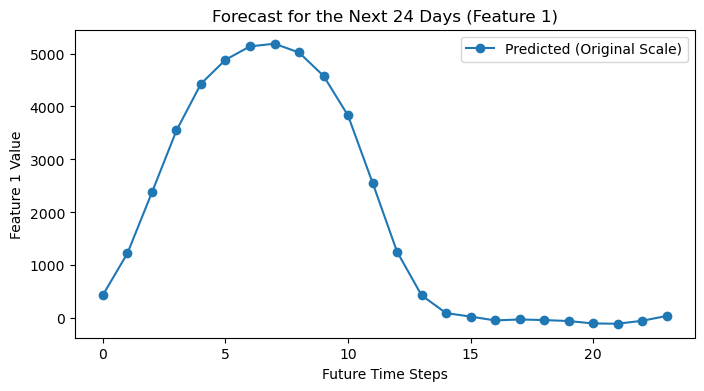

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(n_future), pred_feature1_original, marker='o', label='Predicted (Original Scale)')
plt.xlabel('Future Time Steps')
plt.ylabel('Feature 1 Value')
plt.title('Forecast for the Next {} Days (Feature 1)'.format(n_future))
plt.legend()
plt.show()


In [35]:
import numpy as np

# Retrieve the scaler for feature 1
scaler_feature1 = scalers['scaler_Production']

# Extract the last window from y_test for feature 1
# (This will serve as your historical part.)
last_window_scaled = y_test[-1, :, 0].reshape(-1, 1)  
last_window_original = scaler_feature1.inverse_transform(last_window_scaled).flatten()

# Inverse transform the forecast predictions for feature 1
forecast_scaled = pred_e2d2[0, :, 0].reshape(-1, 1)
forecast_original = scaler_feature1.inverse_transform(forecast_scaled).flatten()



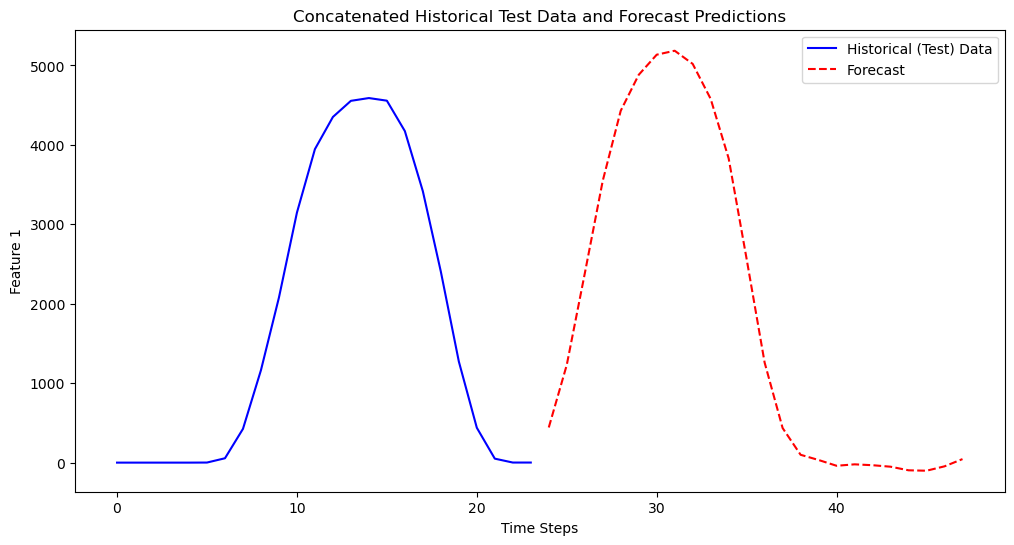

In [36]:
import matplotlib.pyplot as plt

# Create time indices
time_last = np.arange(len(last_window_original))
time_forecast = np.arange(len(last_window_original), len(last_window_original) + len(forecast_original))

plt.figure(figsize=(12, 6))
plt.plot(time_last, last_window_original, label='Historical (Test) Data', color='blue')
plt.plot(time_forecast, forecast_original, label='Forecast', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Feature 1')
plt.title('Concatenated Historical Test Data and Forecast Predictions')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


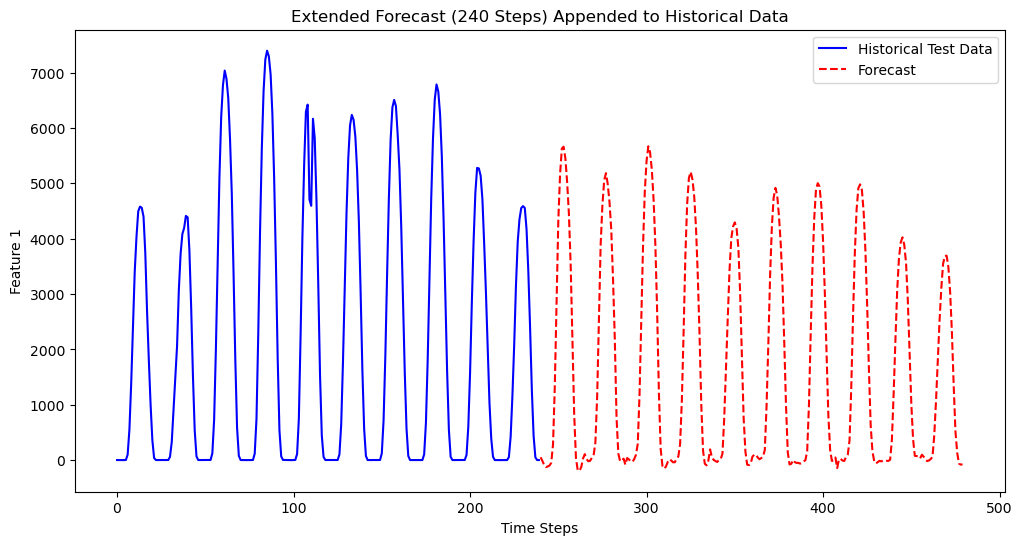

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (adjust as needed)
n_past = 240         # Number of past time steps used by your model
n_future = 24        # Number of time steps predicted at once by your model
forecast_horizon = 240  # Total number of future time steps you want to predict
n_features = test.shape[1]  # Assuming your test data has the same number of features

# Use the last n_past points from your test data as the starting sequence.
# (Assumes your test data is in scaled space, as used for training.)
initial_sequence = test.values[-n_past:]  # shape: (n_past, n_features)

# List to collect forecast chunks
forecast_chunks = []
current_sequence = initial_sequence.copy()

# Loop to generate forecasts until we reach the desired horizon.
for _ in range(0, forecast_horizon, n_future):
    # Reshape the current sequence for model input: (1, n_past, n_features)
    current_input = current_sequence.reshape(1, n_past, n_features)
    
    # Predict the next n_future steps.
    # This returns an array of shape (1, n_future, n_features)
    pred = model_e2d2.predict(current_input)
    pred = pred[0]  # Now shape: (n_future, n_features)
    
    # Store the prediction
    forecast_chunks.append(pred)
    
    # Update the current sequence:
    # Append the new prediction and then keep only the last n_past steps.
    current_sequence = np.concatenate([current_sequence, pred], axis=0)
    current_sequence = current_sequence[-n_past:]

# Concatenate all the forecast chunks to form the complete forecast.
forecast_predictions = np.concatenate(forecast_chunks, axis=0)
# If forecast_chunks produced extra steps (if forecast_horizon isn't a multiple of n_future), trim:
forecast_predictions = forecast_predictions[:forecast_horizon]

# ----- Inverse Transform (for plotting in original scale) -----
# For example, for 'feature1', assuming your scaler is stored with key 'scaler_feature1'
scaler_feature1 = scalers['scaler_Production']

# Inverse transform forecast predictions for feature1.
forecast_feature1_scaled = forecast_predictions[:, 0].reshape(-1, 1)
forecast_feature1_original = scaler_feature1.inverse_transform(forecast_feature1_scaled).flatten()

# Optionally, you can also take the last window of the test data for feature1 as your historical data.
last_window_scaled = test['Production'].values[-n_past:].reshape(-1, 1)
last_window_original = scaler_feature1.inverse_transform(last_window_scaled).flatten()

# ----- Build a Continuous Time Axis and Plot -----
# Create time indices: historical part (from the last test window) and forecast part.
time_historical = np.arange(len(last_window_original))
time_forecast = np.arange(len(last_window_original), len(last_window_original) + forecast_horizon)

plt.figure(figsize=(12, 6))
plt.plot(time_historical, last_window_original, label='Historical Test Data', color='blue')
plt.plot(time_forecast, forecast_feature1_original, label='Forecast', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Feature 1')
plt.title(f'Extended Forecast ({forecast_horizon} Steps) Appended to Historical Data')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


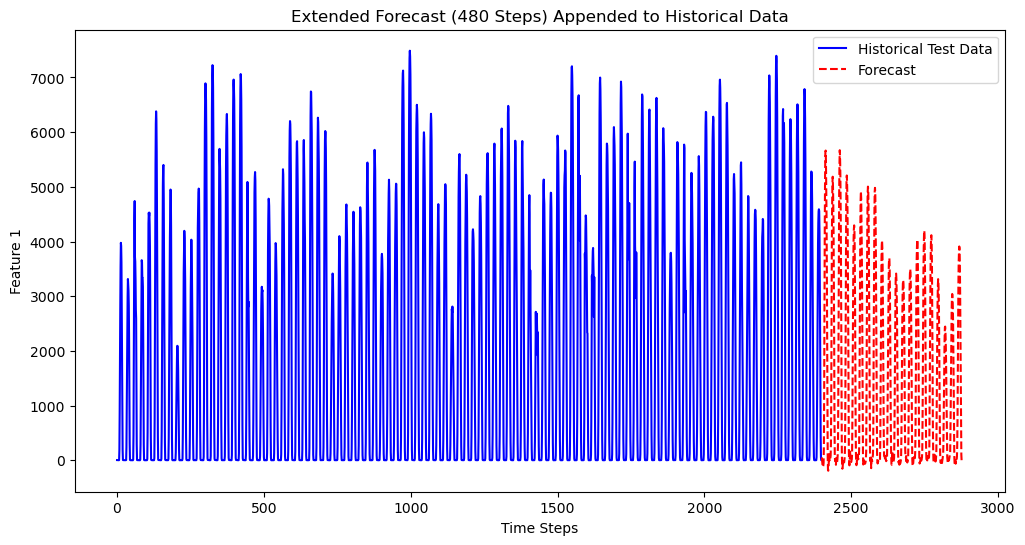

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (adjust as needed)
n_past = 2400         # Number of past time steps used by your model
n_future = 24        # Number of time steps predicted at once by your model
forecast_horizon = 480  # Total number of future time steps you want to predict
n_features = test.shape[1]  # Assuming your test data has the same number of features

# Use the last n_past points from your test data as the starting sequence.
# (Assumes your test data is in scaled space, as used for training.)
initial_sequence = test.values[-n_past:]  # shape: (n_past, n_features)

# List to collect forecast chunks
forecast_chunks = []
current_sequence = initial_sequence.copy()

# Loop to generate forecasts until we reach the desired horizon.
for _ in range(0, forecast_horizon, n_future):
    # Reshape the current sequence for model input: (1, n_past, n_features)
    current_input = current_sequence.reshape(1, n_past, n_features)
    
    # Predict the next n_future steps.
    # This returns an array of shape (1, n_future, n_features)
    pred = model_e2d2.predict(current_input)
    pred = pred[0]  # Now shape: (n_future, n_features)
    
    # Store the prediction
    forecast_chunks.append(pred)
    
    # Update the current sequence:
    # Append the new prediction and then keep only the last n_past steps.
    current_sequence = np.concatenate([current_sequence, pred], axis=0)
    current_sequence = current_sequence[-n_past:]

# Concatenate all the forecast chunks to form the complete forecast.
forecast_predictions = np.concatenate(forecast_chunks, axis=0)
# If forecast_chunks produced extra steps (if forecast_horizon isn't a multiple of n_future), trim:
forecast_predictions = forecast_predictions[:forecast_horizon]

# ----- Inverse Transform (for plotting in original scale) -----
# For example, for 'feature1', assuming your scaler is stored with key 'scaler_feature1'
scaler_feature1 = scalers['scaler_Production']

# Inverse transform forecast predictions for feature1.
forecast_feature1_scaled = forecast_predictions[:, 0].reshape(-1, 1)
forecast_feature1_original = scaler_feature1.inverse_transform(forecast_feature1_scaled).flatten()

# Optionally, you can also take the last window of the test data for feature1 as your historical data.
last_window_scaled = test['Production'].values[-n_past:].reshape(-1, 1)
last_window_original = scaler_feature1.inverse_transform(last_window_scaled).flatten()

# ----- Build a Continuous Time Axis and Plot -----
# Create time indices: historical part (from the last test window) and forecast part.
time_historical = np.arange(len(last_window_original))
time_forecast = np.arange(len(last_window_original), len(last_window_original) + forecast_horizon)

plt.figure(figsize=(12, 6))
plt.plot(time_historical, last_window_original, label='Historical Test Data', color='blue')
plt.plot(time_forecast, forecast_feature1_original, label='Forecast', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Feature 1')
plt.title(f'Extended Forecast ({forecast_horizon} Steps) Appended to Historical Data')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

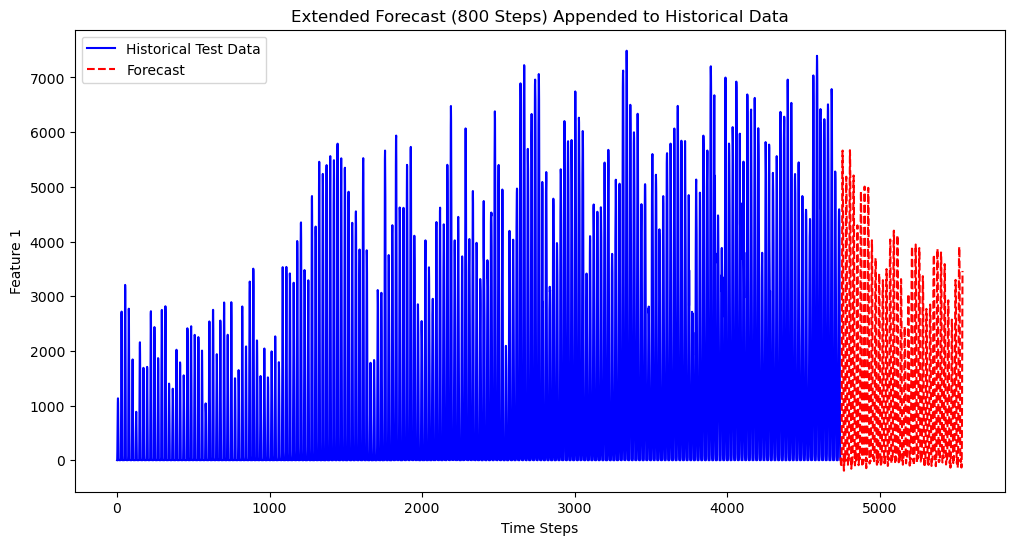

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (adjust as needed)
n_past = 4744         # Number of past time steps used by your model
n_future = 3        # Number of time steps predicted at once by your model
forecast_horizon = 800  # Total number of future time steps you want to predict
n_features = test.shape[1]  # Assuming your test data has the same number of features

# Use the last n_past points from your test data as the starting sequence.
# (Assumes your test data is in scaled space, as used for training.)
initial_sequence = test.values[-n_past:]  # shape: (n_past, n_features)

# List to collect forecast chunks
forecast_chunks = []
current_sequence = initial_sequence.copy()

# Loop to generate forecasts until we reach the desired horizon.
for _ in range(0, forecast_horizon, n_future):
    # Reshape the current sequence for model input: (1, n_past, n_features)
    current_input = current_sequence.reshape(1, n_past, n_features)
    
    # Predict the next n_future steps.
    # This returns an array of shape (1, n_future, n_features)
    pred = model_e2d2.predict(current_input)
    pred = pred[0]  # Now shape: (n_future, n_features)
    
    # Store the prediction
    forecast_chunks.append(pred)
    
    # Update the current sequence:
    # Append the new prediction and then keep only the last n_past steps.
    current_sequence = np.concatenate([current_sequence, pred], axis=0)
    current_sequence = current_sequence[-n_past:]

# Concatenate all the forecast chunks to form the complete forecast.
forecast_predictions = np.concatenate(forecast_chunks, axis=0)
# If forecast_chunks produced extra steps (if forecast_horizon isn't a multiple of n_future), trim:
forecast_predictions = forecast_predictions[:forecast_horizon]

# ----- Inverse Transform (for plotting in original scale) -----
# For example, for 'feature1', assuming your scaler is stored with key 'scaler_feature1'
scaler_feature1 = scalers['scaler_Production']

# Inverse transform forecast predictions for feature1.
forecast_feature1_scaled = forecast_predictions[:, 0].reshape(-1, 1)
forecast_feature1_original = scaler_feature1.inverse_transform(forecast_feature1_scaled).flatten()

# Optionally, you can also take the last window of the test data for feature1 as your historical data.
last_window_scaled = test['Production'].values[-n_past:].reshape(-1, 1)
last_window_original = scaler_feature1.inverse_transform(last_window_scaled).flatten()

# ----- Build a Continuous Time Axis and Plot -----
# Create time indices: historical part (from the last test window) and forecast part.
time_historical = np.arange(len(last_window_original))
time_forecast = np.arange(len(last_window_original), len(last_window_original) + forecast_horizon)

plt.figure(figsize=(12, 6))
plt.plot(time_historical, last_window_original, label='Historical Test Data', color='blue')
plt.plot(time_forecast, forecast_feature1_original, label='Forecast', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Feature 1')
plt.title(f'Extended Forecast ({forecast_horizon} Steps) Appended to Historical Data')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

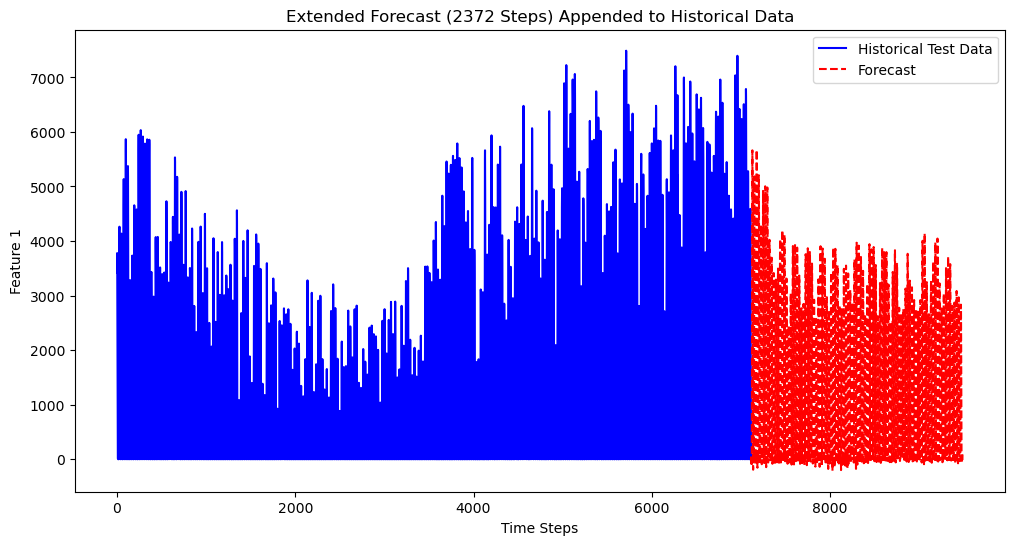

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (adjust as needed)
n_past = 7116         # Number of past time steps used by your model
n_future = 24        # Number of time steps predicted at once by your model
forecast_horizon = 2372  # Total number of future time steps you want to predict
n_features = test.shape[1]  # Assuming your test data has the same number of features

# Use the last n_past points from your test data as the starting sequence.
# (Assumes your test data is in scaled space, as used for training.)
initial_sequence = test.values[-n_past:]  # shape: (n_past, n_features)

# List to collect forecast chunks
forecast_chunks = []
current_sequence = initial_sequence.copy()

# Loop to generate forecasts until we reach the desired horizon.
for _ in range(0, forecast_horizon, n_future):
    # Reshape the current sequence for model input: (1, n_past, n_features)
    current_input = current_sequence.reshape(1, n_past, n_features)
    
    # Predict the next n_future steps.
    # This returns an array of shape (1, n_future, n_features)
    pred = model_e2d2.predict(current_input)
    pred = pred[0]  # Now shape: (n_future, n_features)
    
    # Store the prediction
    forecast_chunks.append(pred)
    
    # Update the current sequence:
    # Append the new prediction and then keep only the last n_past steps.
    current_sequence = np.concatenate([current_sequence, pred], axis=0)
    current_sequence = current_sequence[-n_past:]

# Concatenate all the forecast chunks to form the complete forecast.
forecast_predictions = np.concatenate(forecast_chunks, axis=0)
# If forecast_chunks produced extra steps (if forecast_horizon isn't a multiple of n_future), trim:
forecast_predictions = forecast_predictions[:forecast_horizon]

# ----- Inverse Transform (for plotting in original scale) -----
# For example, for 'feature1', assuming your scaler is stored with key 'scaler_feature1'
scaler_feature1 = scalers['scaler_Production']

# Inverse transform forecast predictions for feature1.
forecast_feature1_scaled = forecast_predictions[:, 0].reshape(-1, 1)
forecast_feature1_original = scaler_feature1.inverse_transform(forecast_feature1_scaled).flatten()

# Optionally, you can also take the last window of the test data for feature1 as your historical data.
last_window_scaled = test['Production'].values[-n_past:].reshape(-1, 1)
last_window_original = scaler_feature1.inverse_transform(last_window_scaled).flatten()

# ----- Build a Continuous Time Axis and Plot -----
# Create time indices: historical part (from the last test window) and forecast part.
time_historical = np.arange(len(last_window_original))
time_forecast = np.arange(len(last_window_original), len(last_window_original) + forecast_horizon)

plt.figure(figsize=(12, 6))
plt.plot(time_historical, last_window_original, label='Historical Test Data', color='blue')
plt.plot(time_forecast, forecast_feature1_original, label='Forecast', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Feature 1')
plt.title(f'Extended Forecast ({forecast_horizon} Steps) Appended to Historical Data')
plt.legend()
plt.show()


In [41]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [42]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,4):
    print("Day ",j,":")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

Production
Day  1 :
MAE-E2D2 :  269.4347044908928
Day  2 :
MAE-E2D2 :  288.6297965429556
Day  3 :
MAE-E2D2 :  310.7233448946442


temperature_2m (°C)
Day  1 :
MAE-E2D2 :  1.2664650134787931
Day  2 :
MAE-E2D2 :  1.3570478191566944
Day  3 :
MAE-E2D2 :  1.47287815295692


wind_speed_10m (km/h)
Day  1 :
MAE-E2D2 :  2.395514913031857
Day  2 :
MAE-E2D2 :  2.8017158231992894
Day  3 :
MAE-E2D2 :  3.165551501590513




In [43]:
from sklearn.metrics import mean_absolute_percentage_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,4):
    print("Day ",j,":")
    print("MAPE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

Production
Day  1 :
MAPE-E2D2 :  2.7367271129265772e+16
Day  2 :
MAPE-E2D2 :  2.1683184768181652e+16
Day  3 :
MAPE-E2D2 :  1.852000590787963e+16


temperature_2m (°C)
Day  1 :
MAPE-E2D2 :  6177922036244.248
Day  2 :
MAPE-E2D2 :  6248009188915.959
Day  3 :
MAPE-E2D2 :  6056470830017.661


wind_speed_10m (km/h)
Day  1 :
MAPE-E2D2 :  0.2892722627181967
Day  2 :
MAPE-E2D2 :  0.34015418757312554
Day  3 :
MAPE-E2D2 :  0.3823951481222774


